# Example notebook: Use _exoscene_ to model the coronagraph image of an exoplanetary system, based on the example PSF model from the Roman Space Telescope Coronagraph Instrument (CGI).

In [1]:
import numpy as np
import scipy.ndimage
import skimage.transform
import os
import pkg_resources
import pandas
import csv

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
plt.style.use('default')
matplotlib.rcParams['image.cmap'] = 'inferno'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.origin'] = 'lower'
#matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
import astropy.table

import exoscene.image
import exoscene.star
import exoscene.planet
from exoscene.planet import Planet

## Results will be stored in this directory (approximately 1.2 MB)

In [2]:
data_dir = os.path.expanduser("~/exoscene_demo_results")

# 1. Use the exoscene Planet class to define a 3-planet system 

### Set star parameters to 47 UMa

Note, with the astroquery package you can directly query SIMBAD:  

from astroquery.simbad import Simbad  
customSimbad = Simbad()  
customSimbad.add_votable_fields('sptype', 'flux(V)', 'pmra', 'pmdec', 'plx')  
scistar_simbad_table = customSimbad.query_object("47 Uma")  

In [3]:
sptype = 'G0V'
Vmag = 5.0
plx = 72.4528 * u.mas
dist = (1 * u.AU / np.tan(plx)).to(u.pc)
print(dist)

13.802089084311351 pc


### Set planet system parameters

In [4]:
system_name = "demo"

T0 = astropy.time.Time('2026-11-01T00:00:00',
                       format='isot', scale='utc').decimalyear * u.year
wavelens = np.array([575]) * u.nanometer

# Saturn parameters copied from the NASA Space Science Data Coordinated Archive 
# planetary factsheet, https://nssdc.gsfc.nasa.gov/planetary/factsheet
rad_saturn = 9.140 * c.R_earth
mass_saturn = 95.16 * c.M_earth

mass_star = 1.0 * c.M_sun
long_node = 320 * u.deg
long_node_d = 290 * u.deg

sma_b = 2.3 * u.AU
sma_c = 4.24 * u.AU # ~ sma_b * 2.5**(2./3) for 5:2 resonance
sma_d = 7.7 * u.AU # ~ sma_c * 3.0**(2./3) for 3:1 resonance
    
mass_b = 1.0 * mass_saturn.to(u.M_jup)
mass_c = 1.0 * u.M_jup
mass_d = 1.0 * mass_saturn.to(u.M_jup)

rad_b = 1.0 * rad_saturn.to(u.R_jup)
rad_c = 1.0 * u.R_jup
rad_d = 1.0 * rad_saturn.to(u.R_jup)

albedo_b = 0.3
albedo_c = 0.4
albedo_d = 0.5
    
P_c = np.sqrt(4 * np.pi**2 / (c.G * (mass_star + mass_c)) 
              * sma_c**3).to(u.year)

t_peri = T0 - 2 * P_c

argperi_b = 291.4 * u.deg
argperi_c = 90 * u.deg
argperi_d = 178.9 * u.deg

planetb = Planet('b', dist=dist, a=sma_b, ecc=0.07, inc=55*u.deg, longnode=long_node,
                 argperi=argperi_b, tperi=t_peri, mplan=mass_b,
                 radius = rad_b, albedo_wavelens=wavelens, albedo_vals=[albedo_b])
    
planetc = Planet('c', dist=dist, a=sma_c, ecc=0.02, inc=57*u.deg, longnode=long_node,
                 argperi=argperi_c, tperi=t_peri, mplan=mass_c,
                 radius = rad_c, albedo_wavelens=wavelens, albedo_vals=[albedo_c])

planetd = Planet('d', dist=dist, a=sma_d, ecc=0.10, inc=48*u.deg, longnode=long_node_d,
                 argperi=argperi_d, tperi=t_peri, mplan=mass_d,
                 radius = rad_d, albedo_wavelens=wavelens, albedo_vals=[albedo_d])

planetlist = [planetb, planetc, planetd]

In [5]:
planetb.argperi, planetc.argperi, planetd.argperi

(<Quantity 291.4 deg>, <Quantity 90. deg>, <Quantity 178.9 deg>)

In [6]:
planetb.P.to(u.year), planetc.P.to(u.year), planetd.P.to(u.year)

(<Quantity 3.48769021 yr>, <Quantity 8.72669502 yr>, <Quantity 21.36398359 yr>)

### Create output data directory if it does not exist

In [7]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
#os.listdir(data_dir)

# 2. Use the exoscene planet_cube() function to plot the time-dependent positions and phases

### The Lambert sphere phase factor is defined by:  
# $\Phi(\beta) = \frac{\sin\beta + (\pi - \beta)\cos\beta}{\pi}$ 
### where $\beta$ is the star-planet-observer angle. (e.g., R. A. Brown, et al., 2009, https://doi.org/10.1088/0004-637X/702/2/1237)

In [8]:
imwidth = 100
pixscale = 0.2 * u.AU
numpts = 101
plot_time_span = 4.0 * u.year
time_series = T0 + np.linspace(0, plot_time_span, numpts) # years
#time_series = np.linspace(0, plot_time_span, numpts) # years

In [9]:
phase_track_img = np.zeros((imwidth, imwidth))

for tt, time in enumerate(time_series):
    res = exoscene.planet.planet_cube(imwidth, pixscale, planetlist, epoch = time)
    for pp in range(len(planetlist)):
        if phase_track_img[ res['coordlist'][pp] ] == 0:
            phase_track_img[ res['coordlist'][pp] ] = res['phasefunclist'][pp]

Text(0.5, 1.0, 'Position and Lambert phase\n From 2026.83 yr to 2030.83 yr')

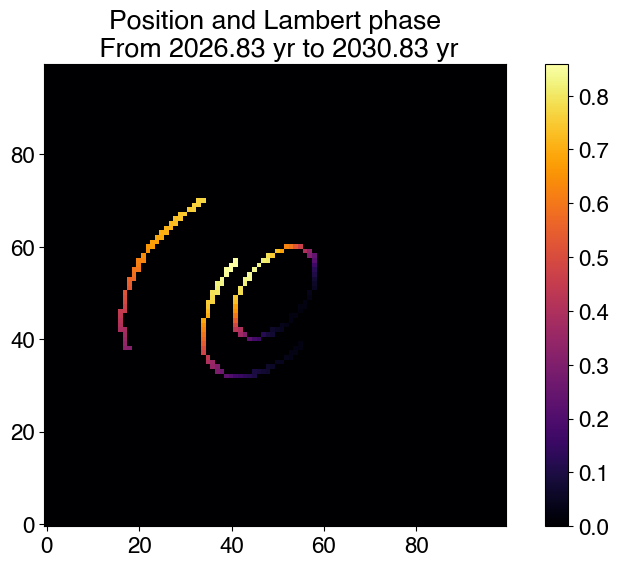

In [10]:
plt.figure(figsize=(10,6))
plt.tight_layout()
plt.imshow(phase_track_img, origin='lower', interpolation='none')
plt.colorbar()
plt.title('Position and Lambert phase\n From {:.2f} to {:.2f}'.format(
          time_series[0], time_series[-1]))

# 3. Use the exoscene compute_ephem() function to make tables of planet ephemeris, phase, and flux ratio

In [11]:
plnt = planetlist[1]
epoch_deltaT_series = T0 + np.array([0, 0.15, 1, 2]) * u.year

tseries, delx, dely, beta, phasefunc, orad = plnt.compute_ephem(tarray = epoch_deltaT_series)
fluxratio = phasefunc * plnt.albedo_vals[0] * (plnt.radius.to(u.AU) / orad)**2

In [12]:
print("beta angle: {:} deg".format(np.rad2deg(beta)))
print("Phi: {:}".format(phasefunc))
print("Flux ratio: {:}".format(fluxratio))

beta angle: [32.99995445 33.55279824 52.01671657 85.62766263] deg
Phi: [0.85827864 0.85396324 0.68847183 0.35735419]
Flux ratio: [4.54117774e-09 4.51722636e-09 3.60479933e-09 1.82396464e-09]


In [13]:
for plnt in planetlist:
    table_fname = os.path.join(data_dir, 'ephem_{:s}_{:}_{:}yrs_{:}epochs.csv'.format(
                               system_name, plnt.name,
                               int(round((np.max(epoch_deltaT_series)
                                          - np.min(epoch_deltaT_series)).value)),
                               epoch_deltaT_series.shape[0]))
    
    exoscene.planet.write_ephem_table(plnt, tarray = epoch_deltaT_series, table_fname = table_fname)    

    ephem_table = pandas.read_csv(table_fname)

    print("Planet {:s} (written to {:s}):".format(plnt.name, os.path.basename(table_fname)))
    print(ephem_table)
    print("")

Planet b (written to ephem_demo_b_2yrs_4epochs.csv):
     t (years)  delta x (mas)  delta y (mas)     phase    r (AU)  \
0  2026.832877     101.810122      -5.798827  0.037307  2.139067   
1  2026.982877     117.182401      34.865681  0.072199  2.147128   
2  2027.832877      27.390529     137.718275  0.653965  2.351257   
3  2028.832877    -135.904177     -51.967373  0.656681  2.444445   

   fluxratio_575  
0   3.714353e-10  
1   7.134427e-10  
2   5.388895e-09  
3   5.006562e-09  

Planet c (written to ephem_demo_c_2yrs_4epochs.csv):
     t (years)  delta x (mas)  delta y (mas)     phase    r (AU)  \
0  2026.832877    -125.605841     105.395815  0.858279  4.155200   
1  2026.982877    -146.540388      78.868121  0.853963  4.155714   
2  2027.832877    -224.808914     -79.747553  0.688472  4.177001   
3  2028.832877    -207.836319    -224.081129  0.357354  4.230613   

   fluxratio_575  
0   4.541178e-09  
1   4.517226e-09  
2   3.604799e-09  
3   1.823965e-09  

Planet d (written to

### High-cadence ephemeris

In [14]:
tstep = 5 * u.day
tspan = 10 * u.year

for plnt in planetlist:
    table_fname = os.path.join(data_dir, 'ephem_{:s}_{:}_{:}yrs.csv'.format(
            system_name, plnt.name, int(round(tspan.value))))
    exoscene.planet.write_ephem_table(plnt, tbeg = T0, tend = T0 + tspan,
                                      tstep = tstep, table_fname = table_fname)
    print('Wrote {:s}'.format(os.path.basename(table_fname)))

Wrote ephem_demo_b_10yrs.csv
Wrote ephem_demo_c_10yrs.csv
Wrote ephem_demo_d_10yrs.csv


# 4. Simulate the coronagraph planet PSF scene using an example coronagraph PSF model, and functions in the exoscene.image modules.

### Load CGI PSF model

In [15]:
hlc_psf_path =  pkg_resources.resource_filename('exoscene', 'data/cgi_hlc_psf')
os.listdir(hlc_psf_path)

['.DS_Store',
 '00README.TXT',
 'os9_psfs_r_offset.fits',
 'os9_psfs_angle_offset.fits',
 'os9_psfs.fits']

In [16]:
psf_cube_fname = os.path.join(hlc_psf_path, 'os9_psfs.fits')
psf_r_fname = os.path.join(hlc_psf_path, 'os9_psfs_r_offset.fits')
psf_angle_fname = os.path.join(hlc_psf_path, 'os9_psfs_angle_offset.fits')

psf_cube = fits.getdata(psf_cube_fname)
psf_hdr = fits.getheader(psf_cube_fname)
print("Shape of PSF model: {:}".format(psf_cube.shape))

Shape of PSF model: (10, 19, 200, 200)


In [17]:
#cx_os6_hires = psf_cube.shape[-1] // 2 # True center of the high-res OS6 array

data_pixscale_as = (21.08 * u.milliarcsecond).to(u.arcsec) # Pixel scale of CGI science camera
hires_pixscale_as = psf_hdr['PIX_AS'] * u.arcsec
hires_pixscale_LoD = psf_hdr['PIXSCALE']

data_scale_fac = hires_pixscale_as.value / data_pixscale_as.value
data_pixscale_LoD = hires_pixscale_LoD / data_scale_fac
print("CCD pixel to model pixel scale factor = {:.3f}".format(data_scale_fac))

r_offsets_LoD = fits.getdata(psf_r_fname)[0, :]
r_offsets_as = r_offsets_LoD * hires_pixscale_as / hires_pixscale_LoD
angles = fits.getdata(psf_angle_fname)[:, 0]

Np_psf_hires = psf_cube.shape[-1]

CCD pixel to model pixel scale factor = 0.238


### Show radial offsets and position angles present in the PSF model cube

In [18]:
print("PSF model radial offsets (lam/D):\n{:}".format(r_offsets_LoD))

PSF model radial offsets (lam/D):
[1.  2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  5.  6.  7.  8.  8.3 8.6
 8.9]


In [19]:
print("PSF model position angles (deg):\n{:}".format(angles))

PSF model position angles (deg):
[ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]


### Apply half-pixel shift to place center at (99.5, 99.5)  
This is necessary to ensure that after binning the PSF model down to the detector resolution, the array center coincides with the image center.

In [20]:
offset_psfs = scipy.ndimage.interpolation.shift(psf_cube, (0, 0, -0.5, -0.5),
                                                order = 1, prefilter=False,
                                                mode = 'constant', cval=0)

Np = offset_psfs.shape[-1]
cx = Np // 2 - 0.5 # New array center in zero-based indices
print("Dimensions of PSF model cube: {:}".format(offset_psfs.shape))
print("New array center along both axes: {:.1f}".format(cx))

Dimensions of PSF model cube: (10, 19, 200, 200)
New array center along both axes: 99.5


### Set detector downsample parameters and test an example

In [21]:
npad = 8 # pad before and after array edge before binning
max_detect_width = 1.1 * u.arcsec
test_hires_psf = exoscene.image.get_hires_psf_at_xy_os9(
        offset_psfs,
        r_offsets_as.value, angles,
        hires_pixscale_as.value,
        delx_as = (-0.1 * u.arcsec).value,
        dely_as = (0.2 * u.arcsec).value,
        cx = cx)

### Get scene array dimensions and data mask

In [22]:
padded_test_hires_psf = np.pad(test_hires_psf,
                               ((npad, npad), (npad,npad)),
                               mode='constant')

cx_padded = padded_test_hires_psf.shape[0] // 2 - 0.5
xcoord_psf = ((np.arange(padded_test_hires_psf.shape[0]) - cx_padded)
              * hires_pixscale_as)
ycoord_psf = xcoord_psf.copy()

binned_test_psf, det_xcoord, det_ycoord = exoscene.image.resample_image_array(
        padded_test_hires_psf, hires_pixscale_as,
        img_xcoord = xcoord_psf, img_ycoord = xcoord_psf,
        det_pixscale = data_pixscale_as,
        det_width = max_detect_width,
        binfac = 10, conserve = 'sum')

print(padded_test_hires_psf.shape)
print(binned_test_psf.shape)
imwidth = binned_test_psf.shape[-1]
print(np.max(test_hires_psf), np.max(binned_test_psf),
      np.max(binned_test_psf) / np.max(test_hires_psf))

# Check conservation of flux
print(np.sum(test_hires_psf), np.sum(binned_test_psf))
np.testing.assert_allclose(
        np.sum(test_hires_psf),
        np.sum(binned_test_psf), rtol=1e-4)
# Coordinate center
np.testing.assert_almost_equal(0, det_xcoord[det_xcoord.shape[0]//2].value)

(216, 216)
(51, 51)
0.00053487055 0.00794841662054061 14.860449297869547
0.18250671 0.18250626010537888


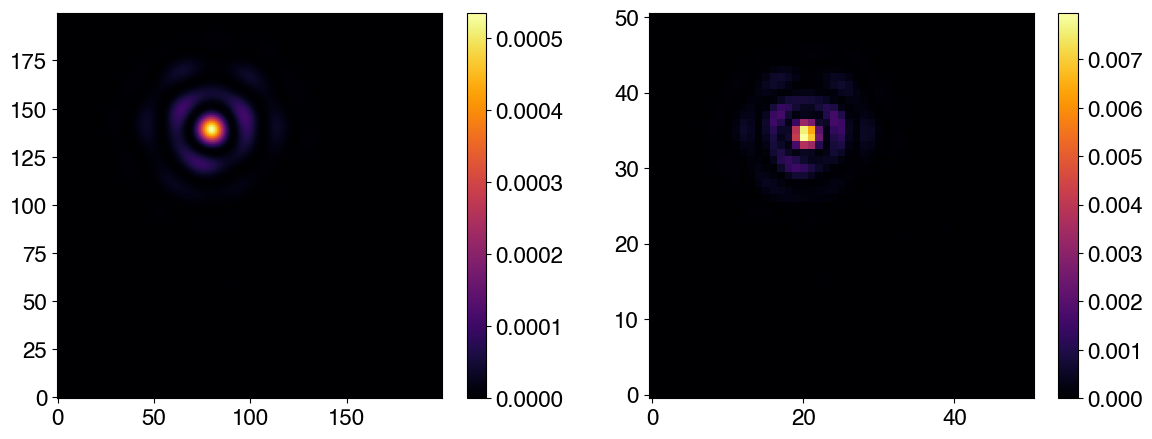

In [23]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(test_hires_psf, origin='lower')
plt.colorbar()
plt.subplot(122)
plt.imshow(binned_test_psf, origin='lower')
plt.colorbar()

### Estimate unocculted star count rate in peak pixel of PSF

In [24]:
(peak_ang_ind, peak_sep_ind, _, _) = np.unravel_index(
        np.argmax(offset_psfs), offset_psfs.shape)
print("Peak angle index = {:d}, peak separation index = {:d}".format(
        peak_ang_ind, peak_sep_ind))

padded_peak_psf = np.pad(offset_psfs[peak_ang_ind, peak_sep_ind],
                         ((npad, npad), (npad,npad)),
                         mode='constant')

binned_peak_psf, _, _ = exoscene.image.resample_image_array(
        padded_peak_psf, hires_pixscale_as,
        img_xcoord = xcoord_psf, img_ycoord = xcoord_psf,
        det_pixscale = data_pixscale_as,
        det_width = max_detect_width,
        binfac = 10, conserve = 'sum')

Peak angle index = 9, peak separation index = 16


### Compute star PSF peak countrate based on collecting area and throughput

In [25]:
minlam = (psf_hdr['minlam'] * u.micron).to(u.nanometer)
maxlam = (psf_hdr['maxlam'] * u.micron).to(u.nanometer)

star_flux = exoscene.star.bpgs_spectype_to_photonrate(spectype = sptype,
                                                      Vmag = Vmag,
                                                      minlam = minlam.value,
                                                      maxlam = maxlam.value)

print("Band-integrated irradiance of host star: {:.3E}".format(star_flux))

Band-integrated irradiance of host star: 5.905E+07 ph / (m2 s)


In [26]:
A_eff = 3.5786 * u.m**2
non_coron_optical_losses = 0.404 # Band 1 CBE at end-of-life

unocc_star_countrate_img = star_flux * binned_peak_psf * A_eff * non_coron_optical_losses
unocc_star_countrate_peakpix = np.max(unocc_star_countrate_img)
print('Stellar PSF peak count rate = {:.2E}'.format(unocc_star_countrate_peakpix))

Stellar PSF peak count rate = 8.42E+05 ph / s


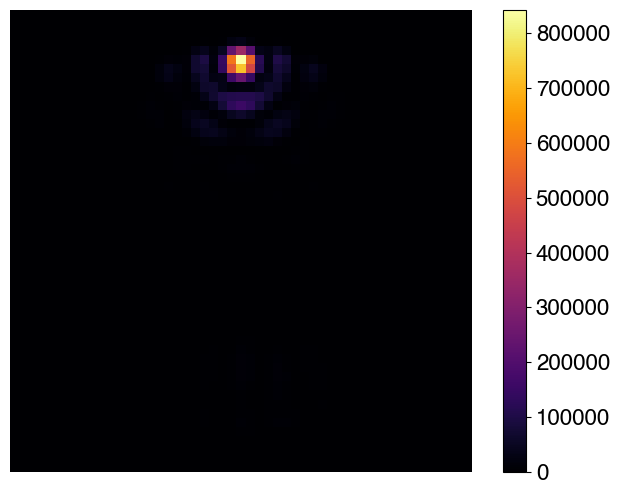

In [27]:
cw = 19
plt.figure(figsize=(8,6))
plt.imshow(unocc_star_countrate_img.value)
plt.axis('off')
#plt.imshow(np.log10(unocc_star_countrate_img.value))
plt.colorbar()
#unocc_star_plot_fname = os.path.join(plot_dir, 'unocc_star_psf.png')
#plt.savefig(unocc_star_plot_fname, dpi=200)

### Define an approximation to the HLC field stop to mask out light from large angular separations

In [28]:
fieldstop_rad = 9.0 # CGI HLC field stop radius in lam/D
xs_p = np.arange(imwidth) - imwidth // 2
ys_p = xs_p.copy()
xxs_p, yys_p = np.meshgrid(xs_p, ys_p)
rrs_p = np.sqrt(xxs_p**2 + yys_p**2)
datamask_nan_ind = np.nonzero(rrs_p >= fieldstop_rad / data_pixscale_LoD)
datamask_nan = np.where(~(rrs_p >= fieldstop_rad / data_pixscale_LoD), 1, np.nan)

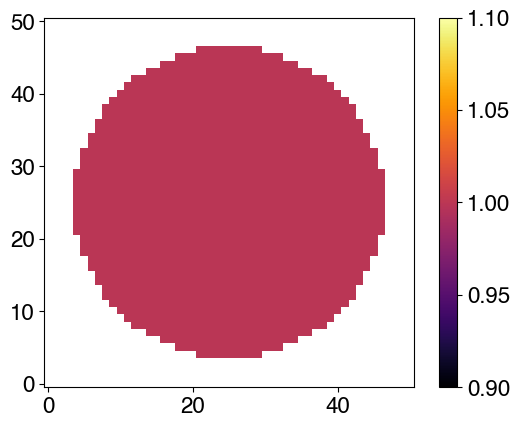

In [29]:
plt.figure()
plt.imshow(datamask_nan)
plt.colorbar()

## Create an animation illustrating the orbital motion of the planet PSFs 

### Load ephemerides

In [30]:
ephem_tables = []
for plnt in planetlist:
    ephem_table_fname = os.path.join(data_dir, 'ephem_{:s}_{:}_{:}yrs.csv'.format(
                                     system_name, plnt.name, int(round(tspan.value))))
    table = astropy.table.Table.read(ephem_table_fname)
    ephem_tables.append(table)
    
ephem_tseries = np.array(ephem_tables[0][ 't (years)' ]) * u.year

table.colnames

['t (years)',
 'delta x (mas)',
 'delta y (mas)',
 'phase',
 'r (AU)',
 'fluxratio_575']

In [31]:
os.path.basename(ephem_table_fname)

'ephem_demo_d_10yrs.csv'

### Set duration and time step

In [32]:
time_span = 10 * u.year
tstep = (5 * u.day).to(u.year)

time_series = np.arange(T0.value,
                        T0.value + time_span.value + tstep.value,
                        tstep.value) * u.year

Nt = len(time_series)

### Loop through time steps and create the time series cube

In [33]:
planet_scene_series = np.zeros((Nt, imwidth, imwidth)) * u.photon / u.second

for tt, time in enumerate(time_series):
    t_ephem = np.argmin(np.abs(ephem_tseries - time))
    for pp, plnt in enumerate(planetlist):
        deltax_as = ephem_tables[pp]['delta x (mas)'][t_ephem] / 1000
        deltay_as = ephem_tables[pp]['delta y (mas)'][t_ephem] / 1000
        flux_ratio = ephem_tables[pp]['fluxratio_575'][t_ephem]
        
        planet_psf = exoscene.image.get_hires_psf_at_xy_os9(
                 offset_psfs, r_offsets_as.value, angles,
                 hires_pixscale_as.value, deltax_as, deltay_as, cx)
        
        padded_planet_psf = np.pad(planet_psf, ((npad, npad), (npad,npad)), mode='constant')
        binned_planet_psf, _, _ = exoscene.image.resample_image_array(
                padded_planet_psf, hires_pixscale_as, 
                img_xcoord = xcoord_psf, img_ycoord = xcoord_psf,
                det_pixscale = data_pixscale_as,
                det_width = max_detect_width,
                binfac = 10, conserve = 'sum')

        planet_scene_series[tt] += (binned_planet_psf * star_flux * flux_ratio
                                    * A_eff * non_coron_optical_losses)

    planet_scene_series[tt] *= datamask_nan

## Display the planet PSF scene at one time sample, in flux ratio units

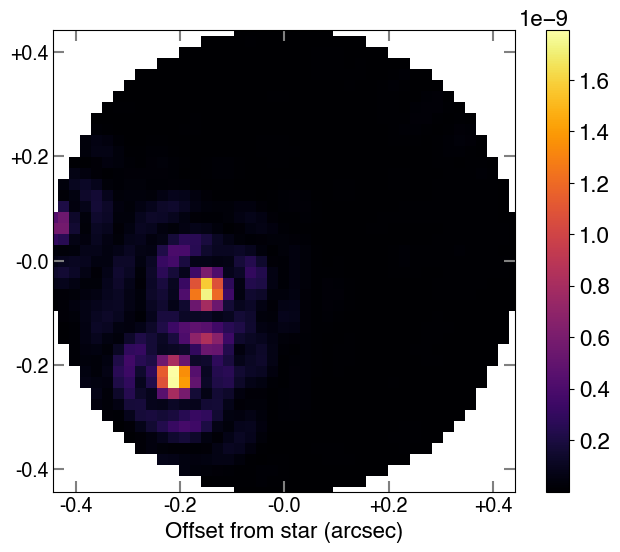

In [34]:
time_show = T0 + 2 * u.year
tt_show = np.argmin(np.abs(time_show - time_series))
crop = 4

plt.figure(figsize = (8,6))
plt.imshow(planet_scene_series[tt_show, crop:-crop, crop:-crop]
           / unocc_star_countrate_peakpix)


xtick_locs = (np.arange(-1, 1, 0.2) / data_pixscale_as.value
              + (imwidth - 2 * crop) // 2)
xtick_labels = ['{:+.1f}'.format(loc) for loc in np.arange(-1, 1, 0.2)]
plt.xticks(xtick_locs, xtick_labels, size=14)
plt.xlim([0, imwidth - 2 * crop - 1])
plt.yticks(xtick_locs, xtick_labels, size=14)
plt.ylim([0, imwidth - 2*crop - 1])
plt.tick_params('both', length=8, width=1.5, which='major', top=True, right=True,
                direction='in', color='gray')
plt.xlabel('Offset from star (arcsec)')

plt.colorbar()

### Store the time series cube as an MPEG file

In [35]:
plt.style.use('dark_background')
matplotlib.rc('axes.spines', top=False, bottom=False, left=False, right=False)
matplotlib.rc('axes', facecolor=(0,0,0,0), edgecolor=(0,0,0,0)) # black out the axes
matplotlib.rc(('xtick', 'ytick'), color=(0,0,0,0)) # black out the ticks
#matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

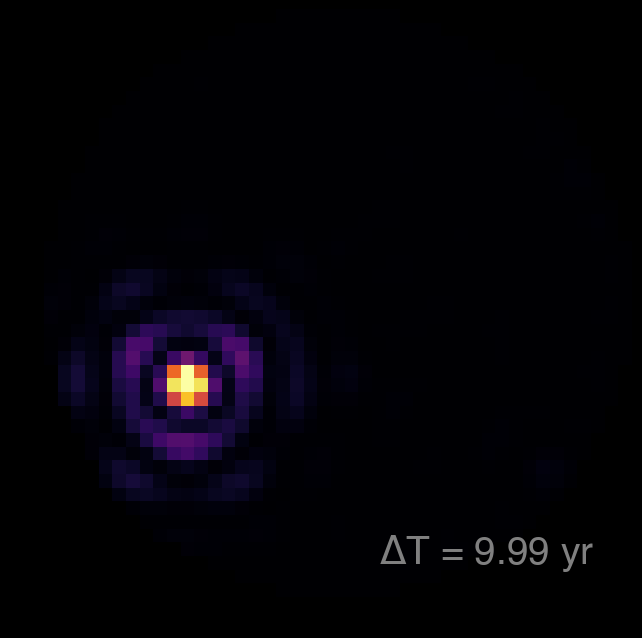

Wrote planet orbit animation to scene_seq_demo_03planets_10yrs.mp4


In [36]:
planet_timeseries_ani_fname = os.path.join(
        data_dir,
        'scene_seq_{:s}_{:02d}planets_{:02d}yrs.mp4'.format(
        system_name, len(planetlist), int(np.round(tspan.value))))

crop = 4
frame_list = []
frame_span = planet_scene_series.shape[0]
frame_stride = 5
vmax = 2E-3

fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

for tt in np.arange(0, frame_span, frame_stride):
    frame = plt.imshow((planet_scene_series[tt, crop:-crop, crop:-crop]).value,
                       vmax = vmax, animated = True)
    tlabel = plt.annotate('$\Delta$T = {:.2f} yr'.format(tt * tstep.value),
                          xy = (24, 2), color='gray', 
                          fontsize=28, animated=True)
    frame_list.append([frame, tlabel])

ani = matplotlib.animation.ArtistAnimation(fig, frame_list,
                                           interval=50, blit=True,
                                           repeat_delay=1000)

writer = matplotlib.animation.FFMpegWriter(fps=30, metadata=dict(artist='Me'),
                                           bitrate=1800)

ani.save(planet_timeseries_ani_fname, writer=writer)

plt.show()

print("Wrote planet orbit animation to {:s}".format(
        os.path.basename(planet_timeseries_ani_fname)))

#### Reset matplotlib parameters

In [37]:
matplotlib.rcdefaults()
#plt.style.use('dark_background')
plt.style.use('default')
matplotlib.rcParams['image.cmap'] = 'inferno'
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['image.origin'] = 'lower'
#matplotlib.rcParams['font.sans-serif'] = 'Helvetica'